In [36]:
import yaml
import os
from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List

# Initialize the LLM (Replace with your preferred model)
llm = ChatOllama(model="llama3.1", device="cuda", temperature=0)

def load_custom_prompts():
    current_dir = ""
    yaml_path = os.path.join(current_dir, "prompts.yaml")
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)
    return data.get("customs", {})

customs = load_custom_prompts()

SECTIONS = [s["name"] for s in customs["sections"]]
QUESTIONS = {s["name"]: s["prompt"] for s in customs["sections"]}

class BusinessPlanState(TypedDict):
    user_input: str
    going_back: bool
    responses: Dict[str, str]
    sections: List[str]
    current_section: int
    history: Dict[str, List[str]]

class BusinessPlanBuilder:
    def __init__(self):
        graph = StateGraph(BusinessPlanState)
        
        initial_question_node = "Ask Initial Question"
        followup_node = "Ask Followup Question"
        compile_node = "Compile Plan"

        graph.add_node(initial_question_node, self.ask_initial_question)
        graph.add_node(followup_node, self.ask_followup_question)
        graph.add_node(compile_node, self.compile_business_plan)

        graph.add_edge(initial_question_node, followup_node)
        graph.add_conditional_edges(followup_node, self.route_next,
                                    {
                                        initial_question_node: initial_question_node,
                                        compile_node: compile_node,
                                        END: END
                                    }
                                    )
        graph.add_edge(compile_node, END)

        graph.set_entry_point(initial_question_node)
        self.graph = graph.compile()

    def invoke(self):
        return self.graph.invoke({
            "user_input": "",
            "going_back": False,
            "responses": {},
            "sections": SECTIONS,
            "current_section": 0,
            "history": {}
        }, {"recursion_limit": 1000})

    def input_handler(self, state: BusinessPlanState, section_name: str, question: str, is_followup_question: bool = False):
        # print("Section Num: ", state["current_section"])
        user_input = input().strip()
        if user_input.lower() in ["exit", "back", "skip", "restart"]:
            user_input = user_input.lower()

        state["user_input"] = user_input

        if section_name not in state["history"]:
            state["history"][section_name] = []

        if user_input == "exit":
            return state

        elif user_input == "back":
            state["history"][section_name] = []
            state["responses"][section_name] = []

            if not is_followup_question:
                state["going_back"] = True
                state["current_section"] = max(state["current_section"] - 1, 0)
            return state
        
        elif user_input == "restart":
            state["history"].clear()
            state["responses"].clear()
            state["current_section"] = 0
            state["going_back"] = True
            return state

        elif user_input == "skip":
            if not is_followup_question:
                state["responses"][section_name] = "Skipped."
                state["responses"][section_name] += "Skipped."
                state["history"][section_name].append(f"Q: {question}\nA: Skipped.")
                state["history"][section_name].append("Q: Followup question not generated.\nA: Skipped.")
            else:  
                state["responses"][section_name] += "Skipped."
                state["history"][section_name].append(f"Q: {question}\nA: Skipped.")
            state["current_section"] += 1
            return state

        # Normal input
        if not is_followup_question:
            state["responses"][section_name] = user_input
            state["history"][section_name].append(f"Q: {question}\nA: {user_input}")
        else:  # follow-up
            state["responses"][section_name] += f"\n\n{user_input}"
            state["history"][section_name].append(f"Q: {question}\nA: {user_input}")
            state["current_section"] += 1
        return state



    def ask_initial_question(self, state: BusinessPlanState):
        state["going_back"] = False

        if state["current_section"] >= len(state["sections"]):
            return state

        section = state["sections"][state["current_section"]]
        question = QUESTIONS[section]

        print(f"\n{section} - {question}")
        state = self.input_handler(state, section, question)

        return state


    def ask_followup_question(self, state: BusinessPlanState):
        if state["going_back"] or state["user_input"] == "exit" or state["current_section"] >= len(state["sections"]):
            return state

        section = state["sections"][state["current_section"]]

        if section not in state["responses"] or state["responses"][section] == "Skipped.":
            return state

        question = QUESTIONS[section]
        initial_response = state["responses"][section]
        followup_prompt = customs["followup_prompt"].format(question=question, response=initial_response)
        followup_question = llm.invoke(followup_prompt).content.strip()

        print(f"{followup_question}")
        state = self.input_handler(state, section, question, True)

        return state

    def route_next(self, state: BusinessPlanState) -> str:
        if state["user_input"] == "exit":
            return END
        elif state["current_section"] >= len(state["sections"]):
            return "Compile Plan"
        else:
            return "Ask Initial Question"

    def compile_business_plan(self, state: BusinessPlanState):
        full_qa = "\n\n".join(["\n".join(qas) for qas in state["history"].values()])
        prompt = customs["compile_plan_prompt"].format(all_qa=full_qa)

        refined_business_plan = llm.invoke(prompt).content.strip()
        disclaimer = "\n\n📌 PLEASE NOTE: The generated business plan is a starting point and may require further refinement and correction."
        refined_business_plan += disclaimer

        state["responses"]["Final Plan"] = refined_business_plan

        print("\n--- Your Complete Business Plan ---\n")
        print(refined_business_plan)

        return state


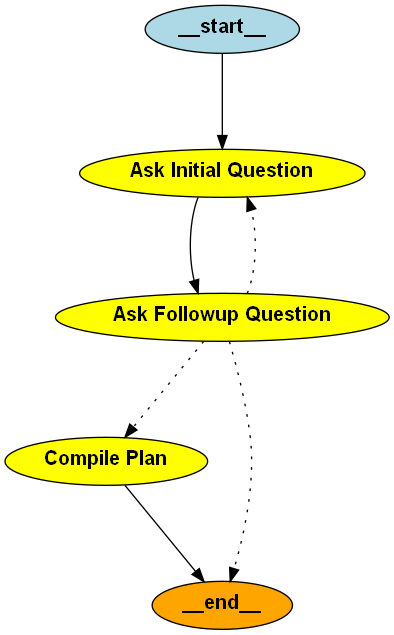

In [28]:
from IPython.display import Image

abot = BusinessPlanBuilder()
Image(abot.graph.get_graph().draw_png())

In [35]:
builder = BusinessPlanBuilder()
result = builder.invoke()


Company Description - Describe your business. What is its name, what problem does it solve, and what makes it unique?
Section Num:  0

Market Analysis - Who is your target audience, and who are your main competitors?
Section Num:  1

Organization and Management - What is your business structure, and who are the key members of your team?
Section Num:  2

Service or Product Line - What products or services do you offer, and how do they benefit customers?
Section Num:  3

Organization and Management - What is your business structure, and who are the key members of your team?
Section Num:  2
What specific roles do you have in place for managing day-to-day operations and making key business decisions?
Section Num:  2

Company Description - Describe your business. What is its name, what problem does it solve, and what makes it unique?
Section Num:  0
What is the name of your business and how does it address the problem you mentioned?
Section Num:  0

Market Analysis - Who is your target aud

In [24]:
for section in result["history"]:
    print(f"\n--- {section} ---\n")
    for qa in result["history"][section]:
        print(qa)


--- Company Description ---

Q: Describe your business. What is its name, what problem does it solve, and what makes it unique?
A: My business is called "EasyFix," and it helps people fix small home repairs quickly. What's unique is that we come to you fast and don't charge a lot.
Agent: What specific types of small home repairs does EasyFix specialize in fixing, and what is the typical scope of work for a single visit?
User: We specialize in things like leaky faucets, broken door handles, and fixing small holes in walls. A typical visit would be fixing one or two of these kinds of problems.

--- Market Analysis ---

Q: Who is your target audience, and who are your main competitors?
A: My target audience is homeowners or renters who need quick fixes, and my competitors are local handymen and big services like HomeAdvisor.
Agent: What specific characteristics or demographics define your target audience (e.g., age range, income level, geographic location), and how do you plan to reach t

In [25]:
print(result["responses"]["Final Plan"])

**EasyFix Business Plan**

**Executive Summary**

EasyFix is a small home repair service that specializes in quick fixes for homeowners or renters. Our mission is to provide affordable, fast, and reliable solutions for common household problems such as leaky faucets, broken door handles, and small holes in walls. With a focus on customer satisfaction and a personal touch, we aim to become the go-to service for quick home repairs.

**Company Description**

EasyFix is a sole proprietorship owned and operated by [Your Name]. Our business structure will be small, with you running things and possibly hiring a couple of handymen to assist with repairs. We will operate in the city, targeting homeowners or renters aged 30-50, middle-income individuals.

**Market Analysis**

Our target audience is homeowners or renters who need quick fixes for common household problems. According to our research, this demographic is likely to be people in their 30s to 50s, living in the city, and having a moder